# Setup

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!mamba  install  -q -y -c rapidsai -c conda-forge -c nvidia cucim cuml #cupy
!git clone https://github.com/MaximilianHoffmann/test.git
!pip install --ignore-installed  --quiet ./test
!wget "https://owncloud.charite.de/owncloud/index.php/s/zc9NTVJMw8AiuQn/download?path=%2F&files=20230611_export.h5" -O data.h5

# Analysis

In [1]:
import h5py as h5
import numpy as np
from tqdm.auto import tqdm
from wholebrain import util,cluster,spatial,regression
from functools import partialmethod
from matplotlib import pyplot as plt
import xarray as xr
import matplotlib
# TURN TQDM ON/OFF
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
i2m=25.4
c_voxel="#3B7BBF"
c_random='#F9A91C'
c_pca='#ED1B50'


/home/hoffmmax/mambaforge/envs/hoffmann_et_al/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hoffmmax/mambaforge/envs/hoffmann_et_al/lib/python3.8/site-packages/rmm/__init__.py:56: FutureWarning: Use of 'rmm.rmm_cupy_allocator' is deprecated and will be removed. 'rmm_cupy_allocator' now lives in the 'rmm.allocators.cupy' sub-module, please update your imports.
  warnings.warn(


In [2]:
def load_dset(name):
    with h5.File('./data.h5','r') as fh5:
        return fh5[name]['coords'][:],fh5[name]['dff'][:],fh5[name]['traces'][:]

In [3]:
data={}
with h5.File('./data.h5','r') as fh5:
    names=[n for n in fh5.keys()]
    print('Datasets:', names)

Datasets: ['dset_0', 'dset_1', 'dset_2', 'dset_3', 'dset_4', 'dset_5']


In [4]:
n_repeats=3
alpha_repeats=3

pars={"global": {"stripe_period":300,
                 "val_fraction":0.2,
                 "test_fraction":0.2,
                 "target_fraction":0.1,
                 "alphas":np.geomspace(1,10000,20).tolist(),
                "alpha_repeats":alpha_repeats
             },
 "pca_reg": 
 {"do":True, "dims_list":np.geomspace(1, 1500, 200).tolist(),"n_repeats":n_repeats},
 "random_predictors": 
 {"do":True, "n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"n_repeats":n_repeats},
 "voxelate":
 {"do":True, "s_bins_dim": [5,10,25,50,100,150,200,500],"n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"n_repeats":n_repeats},
"r2_scan":{"do":True, "s_bins":[5,10,25,50,100,150,200,500],"n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"alphas":np.geomspace(1,10000,20).tolist(),"n_repeats":n_repeats},
     }

In [5]:
coords,dff,traces=load_dset(names[0])
dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1))] # Centered Data without NANs ( motion)

In [6]:
cv_train,cv_test,cv_val=util.create_crossvalidation_mask(dff_mu)
n_targets = int(dff_mu.shape[1] * pars["global"]["target_fraction"])
max_npred=(1-pars['global']['target_fraction'])*dff_mu.shape[1]

### Bi-crossvalidated PCA

In [7]:
r2_bcvpca = util.pca_run(dff_mu, cv_test + cv_train,pars["pca_reg"]["dims_list"],n_targets=n_targets, n_repeats=pars["pca_reg"]["n_repeats"],)


#### Determination of regularization parameter for ridge regression

In [8]:
print("Alpha Scan for regression")
   
alphas=pars["global"]["alphas"]
r2_l=[]
s_bin=pars["voxelate"]["s_bins_dim"]

for alpha in alphas:
        nnz, r2_voxelate = util.voxelate_regression(
            [s_bin[len(s_bin)//2]],
            dff_mu,
            coords,
            cv_test,
            n_targets=n_targets,
            n_repeats=pars["global"]["alpha_repeats"],
            alpha=alpha,
        )
        r2_l.append(r2_voxelate.mean()) 
        
#Update global alpha parameter
pars["global"]["alpha"]=alphas[np.argmax(r2_l)]

Alpha Scan for regression


#### Voxelized regression with determined alpha parameter

In [9]:
nnz, r2_voxelate = util.voxelate_regression(
    pars["voxelate"]["s_bins_dim"],
    dff_mu,
    coords,
    cv_test + cv_train,
    n_targets=n_targets,
    n_repeats=pars["voxelate"]["n_repeats"],
    alpha=pars["global"]["alpha"],
)
       


/home/hoffmmax/repos/hoffmann_et_al_2023/src/wholebrain/regression.py:85: RuntimeWarning: invalid value encountered in matmul
  XtXa = (X.T @ X) + xp.eye(X.shape[1]) * alpha


#### Random Predictors

In [10]:

r2_rand_pred = util.ridge_random(
    dff_mu,
    pars["random_predictors"]["n_pred_list"],
    cv_test + cv_train,
    n_repeats=pars["random_predictors"]["n_repeats"],
    alpha=pars["global"]["alpha"],
    n_targets=n_targets,
)


/tmp/ipykernel_35658/558024558.py:25: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim(0,None)


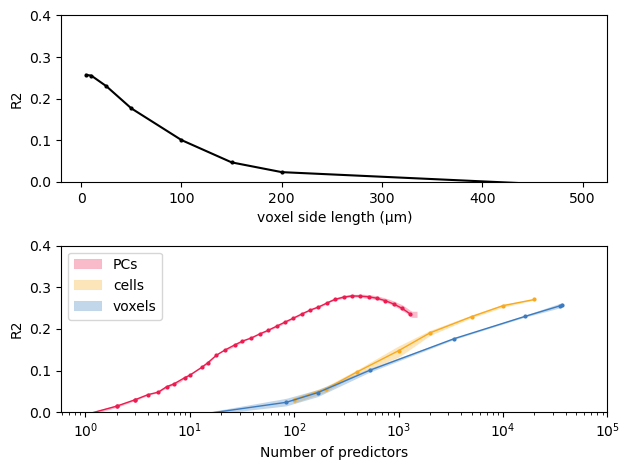

In [11]:
fig,ax=plt.subplots(2,1)
ms=2
lw=1
ax[0].plot(r2_voxelate.voxelsize,r2_voxelate.mean('n_repeats'), '-',color='k',marker='o',markersize=ms)
ax[0].set(xlabel='voxel side length (µm)', ylabel='R2')
ax[0].set_xticks(np.arange(0,600,100))
ax[0].set_ylim(0,0.4)
ax[1].plot(np.floor(r2_bcvpca.dimensions)[::5],r2_bcvpca.mean('n_repeats')[::5],color=c_pca,linestyle='-',marker='o',markersize=ms,alpha=1,lw=lw)
ax[1].fill_between(np.floor(r2_bcvpca.dimensions),r2_bcvpca.quantile(0.05,'n_repeats'),r2_bcvpca.quantile(0.95,'n_repeats'),alpha=0.3,color=c_pca,lw=0.01, label='PCs')


ax[1].plot(r2_rand_pred.n_predictors,r2_rand_pred.mean('n_repeats'),color=c_random,linestyle='-',marker='o',markersize=ms,alpha=1,lw=lw)
ax[1].fill_between(r2_rand_pred.n_predictors,r2_rand_pred.quantile(0.05,'n_repeats'),r2_rand_pred.quantile(0.95,'n_repeats'),alpha=0.3,color=c_random,lw=0.01, label='cells')

ax[1].plot(nnz.mean('n_repeats'),r2_voxelate.mean('n_repeats'),c=c_voxel,linestyle='-',marker='o',markersize=ms,alpha=1,lw=lw)
ax[1].fill_between(nnz.mean('n_repeats'),r2_voxelate.quantile(0.05,'n_repeats'),r2_voxelate.quantile(0.95,'n_repeats'),alpha=0.3,color=c_voxel,lw=0.01, label='voxels')


ax[1].set_xscale('log')
ax[1].set_xlabel('Number of predictors')
ax[1].set_ylabel('R2')
ax[1].legend()
ax[1].set_xticks([10**x for x in range(0,6)])
ax[1].set_ylim(0,0.4)
ax[1].set_xlim(0,None)
plt.tight_layout()

### De-coupling R2 and voxelsize

In [40]:
R2s = util.voxelate_alpha_scan(
        pars["r2_scan"]["s_bins"],
        pars["r2_scan"]["n_pred_list"],
        coords,
        dff_mu,
        cv_test,
        cv_train,
        pars["r2_scan"]["alphas"],
        n_repeats=pars["global"]["alpha_repeats"],
        n_targets=n_targets,
    )
alphas_max = R2s.mean("repeats").idxmax("alphas")

R2s_val, batch_id = util.voxelate_all(
    pars["r2_scan"]["s_bins"],
    pars["r2_scan"]["n_pred_list"],
    coords,
    dff_mu,
    cv_train + cv_test,
    alphas_max,
    n_repeats=pars["r2_scan"]["n_repeats"],
    n_targets=n_targets,
)


In [13]:
##### R2 Plot


opac=0.1
var=xr.DataArray(dff_mu[cv_val].var(0),dims='cells')
fig,ax=plt.subplots()
for nn in R2s_val.num_predictors:
    color = next(ax._get_lines.prop_cycler)['color']
    vox_list=[]
    for vx_sz in R2s_val.voxel_size:
        batch_means=[]
        for irep in R2s_val.repeats:
            arr=batch_id[0].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)
            arr_r2=R2s_val[0].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)

            batch_nr,indx=np.unique(arr,return_inverse=True)

            for ii in range(max(indx)):
                batch_mask=(indx==ii)
                batch_means.append(np.average(arr_r2[batch_mask],weights=var[batch_mask]))
        vox_list.append(batch_means)

    ax.plot(R2s_val.voxel_size,[np.nanmean(x) for x in vox_list],ls='-',c=color,label=f'{int(nn)}')
    ax.fill_between(R2s_val.voxel_size,[np.nanpercentile(x,95) for x in vox_list],[np.nanpercentile(x,5) for x in vox_list],alpha=opac,color=color,lw=0.01)

    vox_list=[]
    for vx_sz in R2s_val.voxel_size:
        batch_means=[]
        for irep in R2s_val.repeats:
            arr=batch_id[1].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)
            arr_r2=R2s_val[1].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)

            batch_nr,indx=np.unique(arr,return_inverse=True)

            for ii in range(max(indx)):
                batch_mask=(indx==ii)
                batch_means.append(np.average(arr_r2[batch_mask],weights=var[batch_mask]))
        vox_list.append(batch_means)

    ax.plot(R2s_val.voxel_size,[np.nanmean(x) for x in vox_list],ls='--',c=color, label='')
    ax.fill_between(R2s_val.voxel_size,[np.nanpercentile(x,95) for x in vox_list],[np.nanpercentile(x,5) for x in vox_list],alpha=opac,color=color,lw=0.01)#,hatch="*")
ax.set_ylim(0,0.5)
plt.plot([], [],' ',ls='--', label="shuffled")
ax.legend(ncol=2,loc='upper right')
ax.set(xlabel='voxel side length (µm)', ylabel='R2')

NameError: name 'os' is not defined